# *Parabolic morphology and geodesic dilation-based volumetric cartilage thickness estimation*

- By: *[Matthew McCormick](https://github.com/thewtex), Serena Bonaretti, Marc Niethammer, 2024*  
- Code license: *Apache 2.0*
- Narrative license: *CC-BY*  
- How to cite: *Please cite [as described here](https://github.com/uncbiag/OAI_analysis_2?tab=readme-ov-file#citation)*.

  
**Table of contents**
  
[Computational workflow](#Computational-workflow)   
[Dependencies](#Dependencies)  
[References](#ref)  
[Acknowledgments](#thanks)

---
# Aims

- *Describe a **novel algorithm for precise, local estimation of cartilage thickness directly from a probability volume**. This algorithm is generated from **parabolic morphology-based distance maps** and **iterative grayscale geodesic dilations**.*  
- *In this example, we **visually walk through the steps** of the algorithm **on a knee femoral cartilage volume**.*

This approach:

1. Is **simple, fast, and accurate**.
2. Trivially **handles complex geometries and topologies** such as highly curved regions, holes, islands, and peninsulas.
3. Results in a **thickness volume** that can be **easily mapped into a common reference** space with a registration transformation.

---

## *Computational workflow*

- Installations:  

In [ ]:
import sys

!{sys.executable} -m pip install --pre itk itk-parabolicmorphology "itkwidgets[all]>=1.0a40" watermark

- Imports:  

In [1]:
import itk
from itkwidgets import view
import numpy as np
from enum import Enum

- Functions:

In [2]:
def probability_mask(probability, inside_value=10.0):
    """Create a binary mask from a probability image. The probability image's range is [0, 1.0]."""
    mask = itk.binary_threshold_image_filter(probability, lower_threshold=0.5, inside_value=inside_value, outside_value=0.0)
    return mask

class DistanceMapMethod(str, Enum):
    signed_maurer = 'signed_maurer'
    parabolic_morphology = 'parabolic_morphology'

def masked_distance(mask, method=DistanceMapMethod.parabolic_morphology):
    """Distance map in physical distance units to the edge of the mask from inside the mask."""
    if method is DistanceMapMethod.signed_maurer:
        distance = itk.signed_maurer_distance_map_image_filter(mask.astype(np.uint8), inside_is_positive=True)
    elif method is DistanceMapMethod.parabolic_morphology:
        distance = itk.morphological_signed_distance_transform_image_filter(mask.astype(np.uint8), inside_is_positive=True)
    masked_distance = itk.mask_image_filter(distance, mask_image=mask.astype(itk.SS))
    return masked_distance

def masked_distance_pixels(mask, method=DistanceMapMethod.parabolic_morphology):
    """Distance map in pixel units to the edge of the mask from inside the mask."""
    if method is DistanceMapMethod.signed_maurer:
        distance_pixels = itk.signed_maurer_distance_map_image_filter(mask.astype(np.uint8), inside_is_positive=True, use_image_spacing=False)
    elif method is DistanceMapMethod.parabolic_morphology:
        distance_pixels = itk.morphological_signed_distance_transform_image_filter(mask.astype(np.uint8), inside_is_positive=True, use_image_spacing=False)
    masked_distance_pixels = itk.mask_image_filter(distance_pixels, mask_image=mask.astype(itk.SS))
    return masked_distance_pixels
    
def propagate_thickness(distance, distance_pixels, mask, max_distance=1000.0):
    """Propagate the thickness from a masked distance map to boundaries of the mask.
    
    max_distance (pixel units) must be larger than the largest thickness.
    """
    n_dilations = int(np.ceil(np.max(distance_pixels)))
    thickness = distance
    for iteration in reversed(range(1, n_dilations)):
        distance_pixels_mask = itk.binary_threshold_image_filter(distance_pixels,
                                                                 lower_threshold=float(iteration),
                                                                 inside_value=max_distance,
                                                                 outside_value=0.0)
        masked_thickness = itk.mask_image_filter(thickness,
                                                 mask_image=distance_pixels_mask.astype(itk.SS),
                                                 masking_value=0)
        dilated = itk.grayscale_geodesic_dilate_image_filter(marker_image=masked_thickness,
                                                             mask_image=distance_pixels_mask.astype(itk.F),
                                                             run_one_iteration=True,
                                                             fully_connected=True,
                                                             ttype=(type(distance), type(distance)))
        masked_thickness_comp = np.where(np.asarray(distance_pixels_mask) != max_distance, np.asarray(thickness), 0)
        masked_thickness_comp = itk.image_from_array(masked_thickness_comp)
        masked_thickness_comp.CopyInformation(thickness)

        thickness = itk.add_image_filter(dilated, masked_thickness_comp)
    return thickness

- Variables and constants:

In [3]:
mask_inside_value = 10.0
# a value larger than the maximum possible thickness in pixel units
max_distance = 100.0

- *Workflow*:

### Visual algorithm

In [4]:
# Load a femoral cartilage probability map. This was generate by the oai-analysis package's deep learning segmentation method.
fc_probmap = itk.imread('../oai-analysis-test-data/colab_case/FC_probmap.nii.gz')


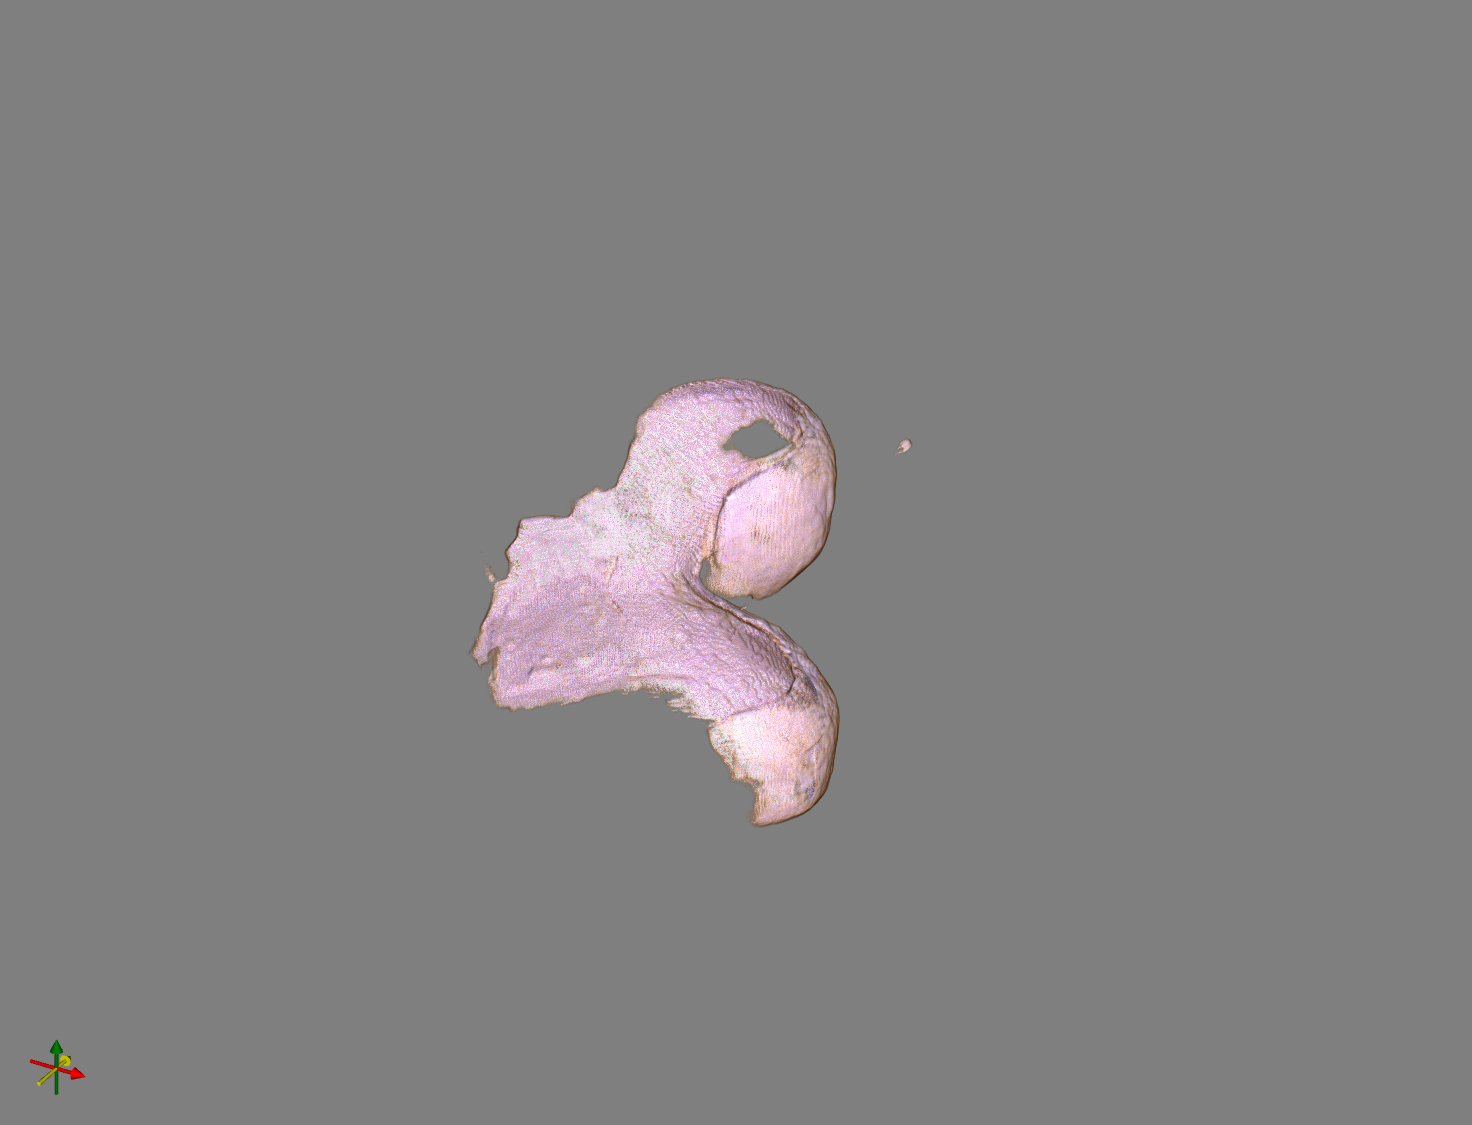
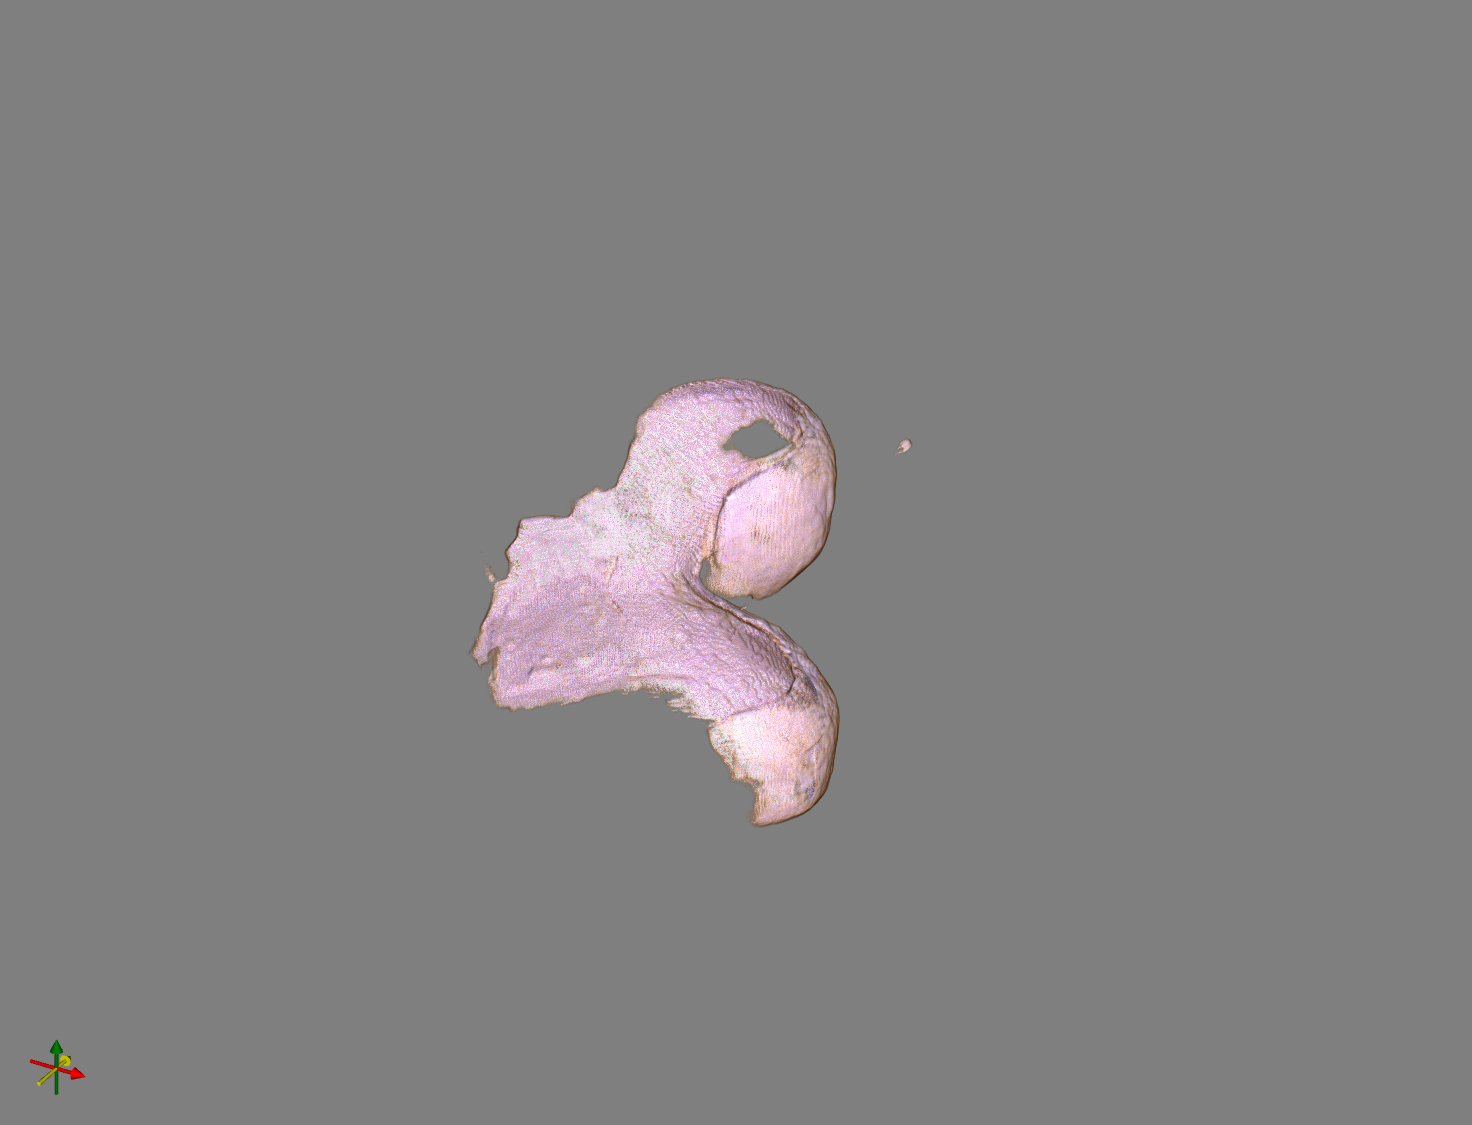

<IPython.core.display.Javascript object>

In [5]:
view(fc_probmap)

In [6]:
# Compute a binary mask from the cartilage segmentation probability 
mask = probability_mask(fc_probmap, mask_inside_value)


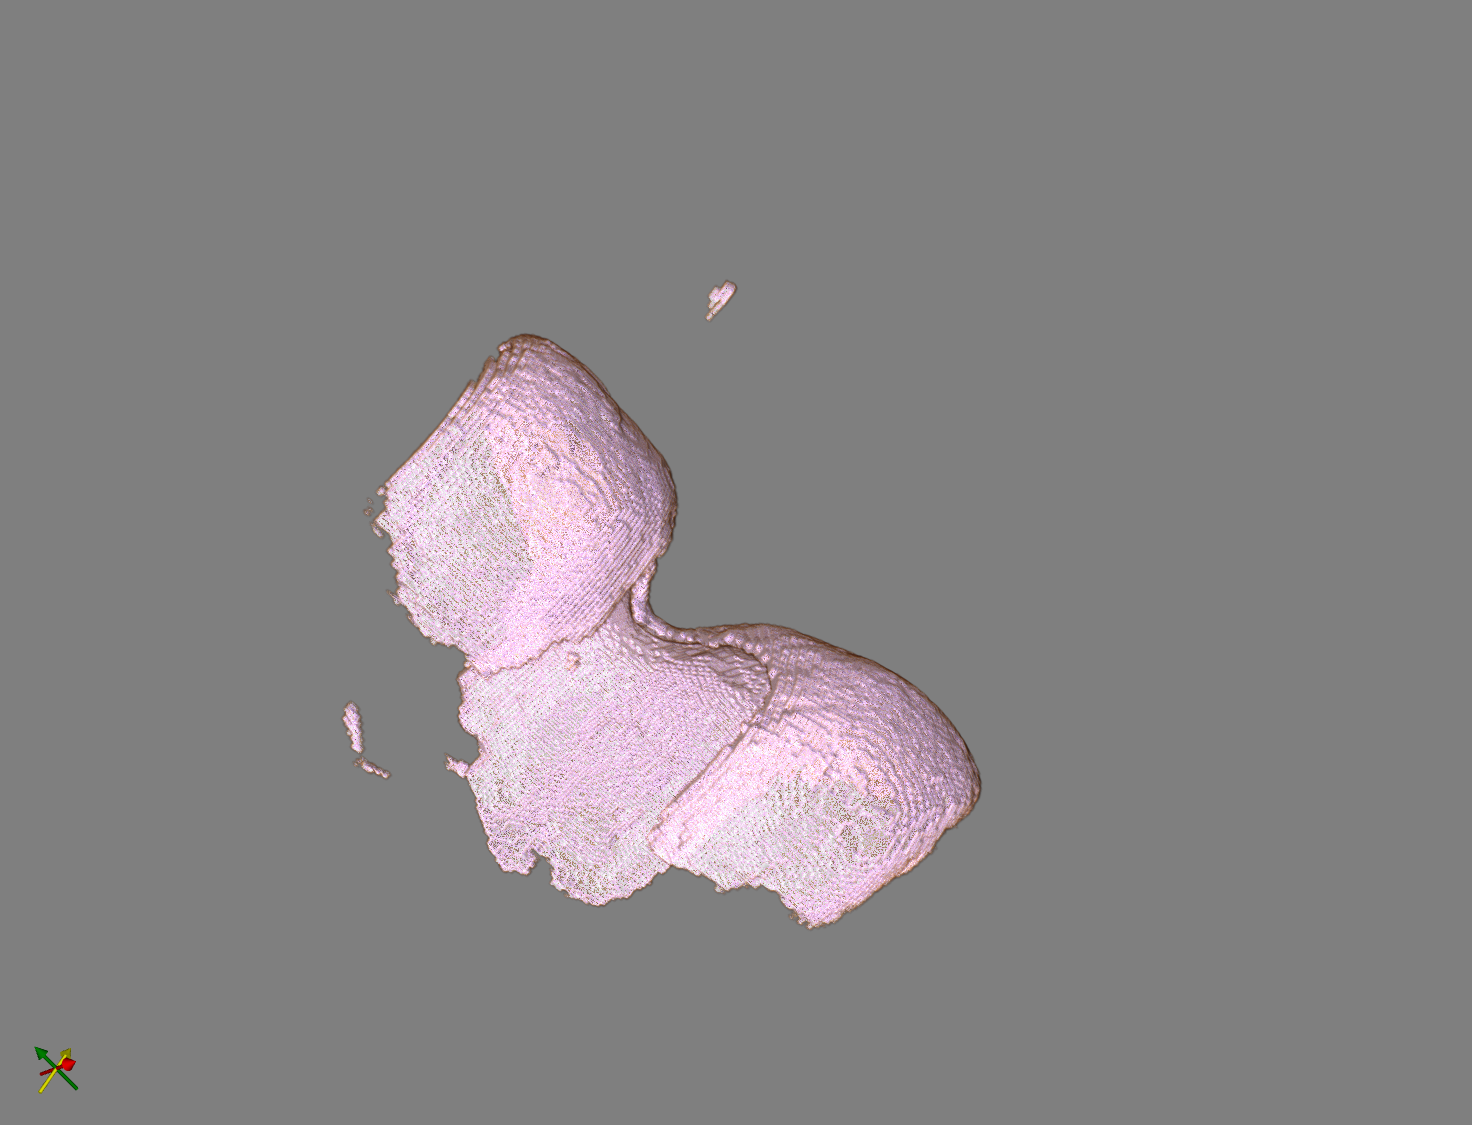
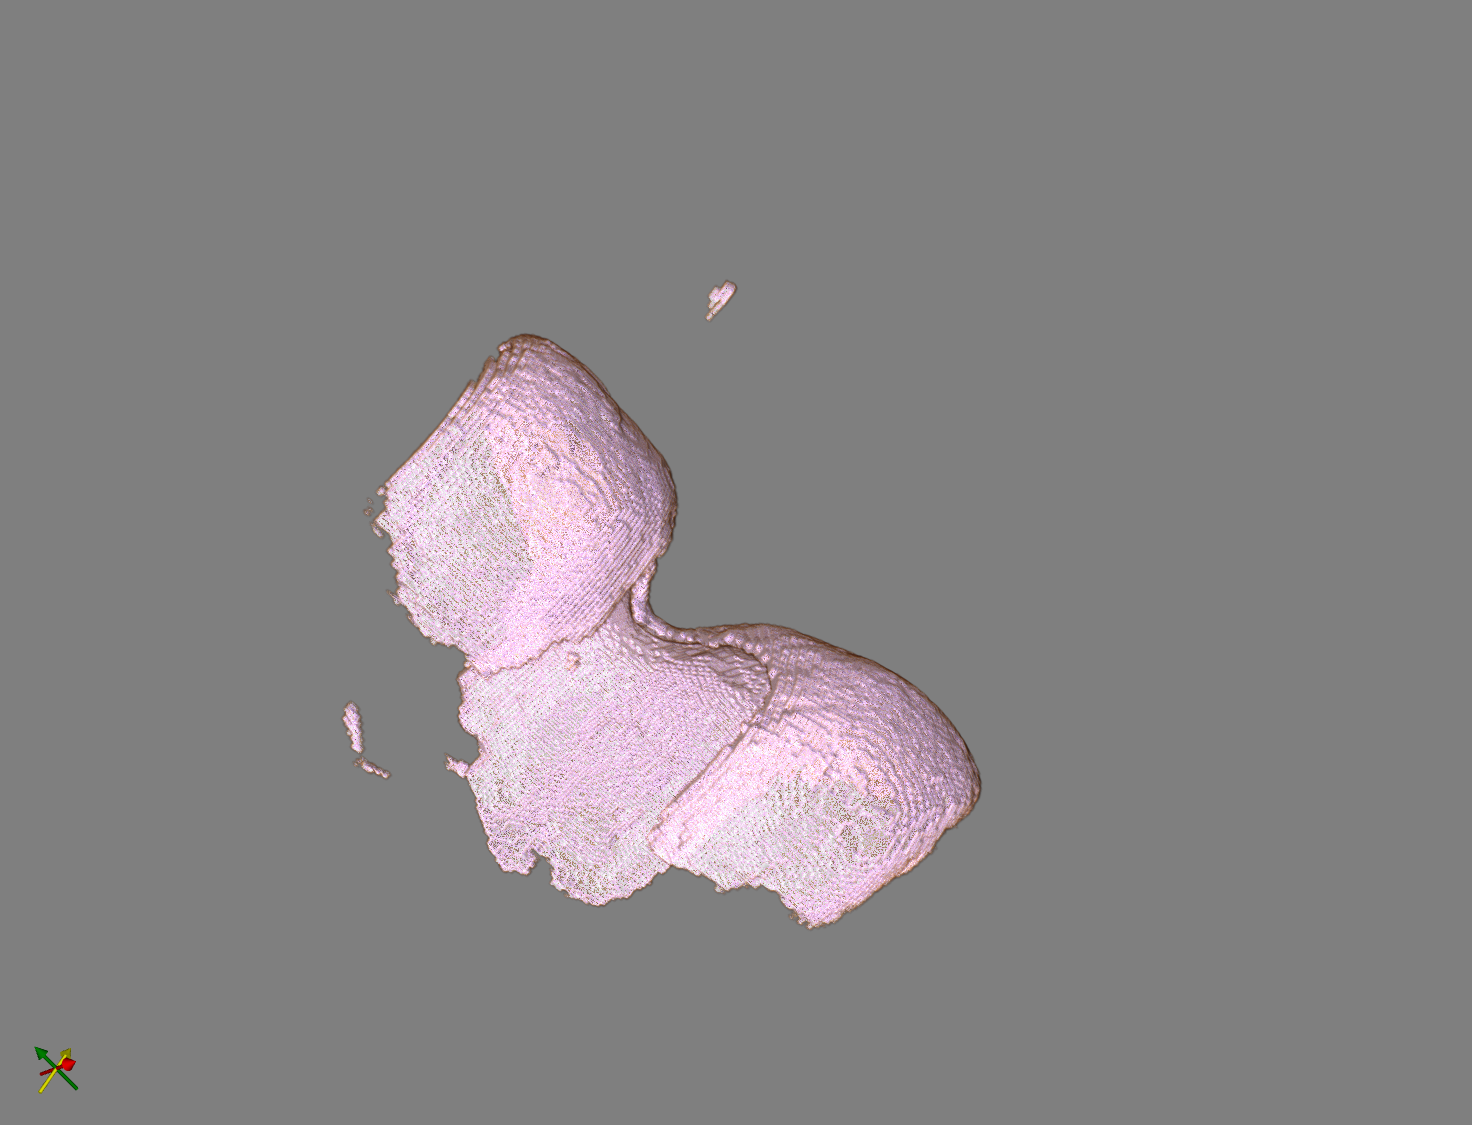

<IPython.core.display.Javascript object>

In [7]:
view(image=mask)

In [8]:
# Compute the distance map to the edge of the mask from inside the mask.
distance = masked_distance(mask)


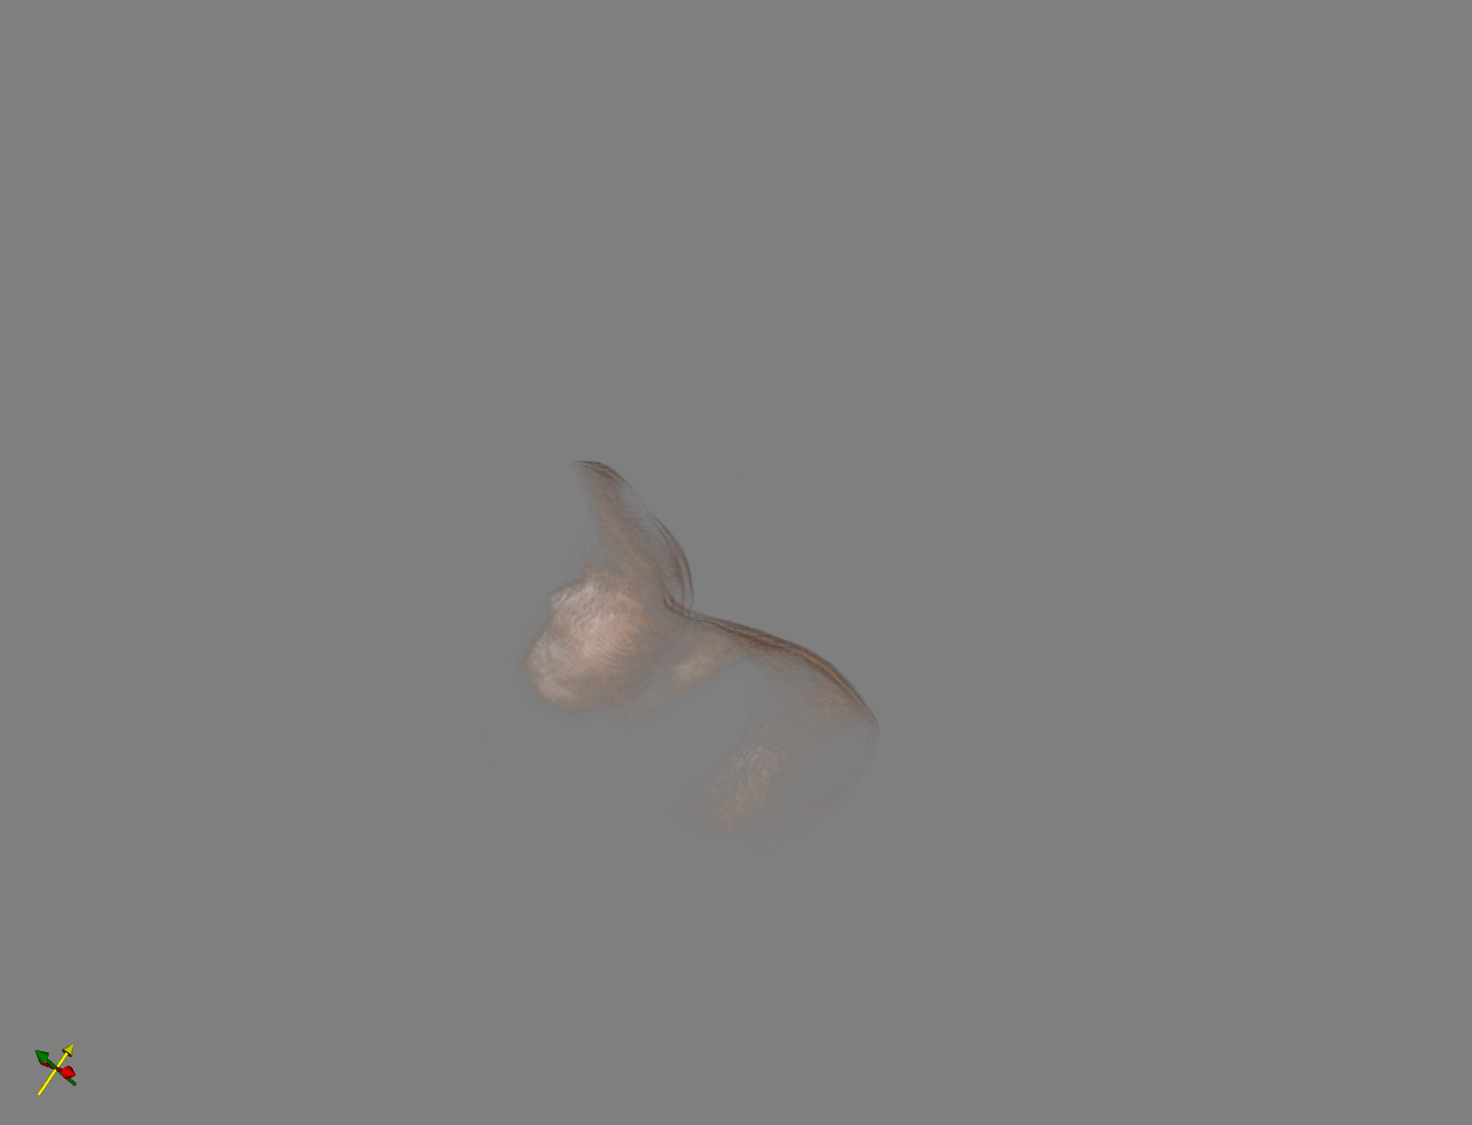
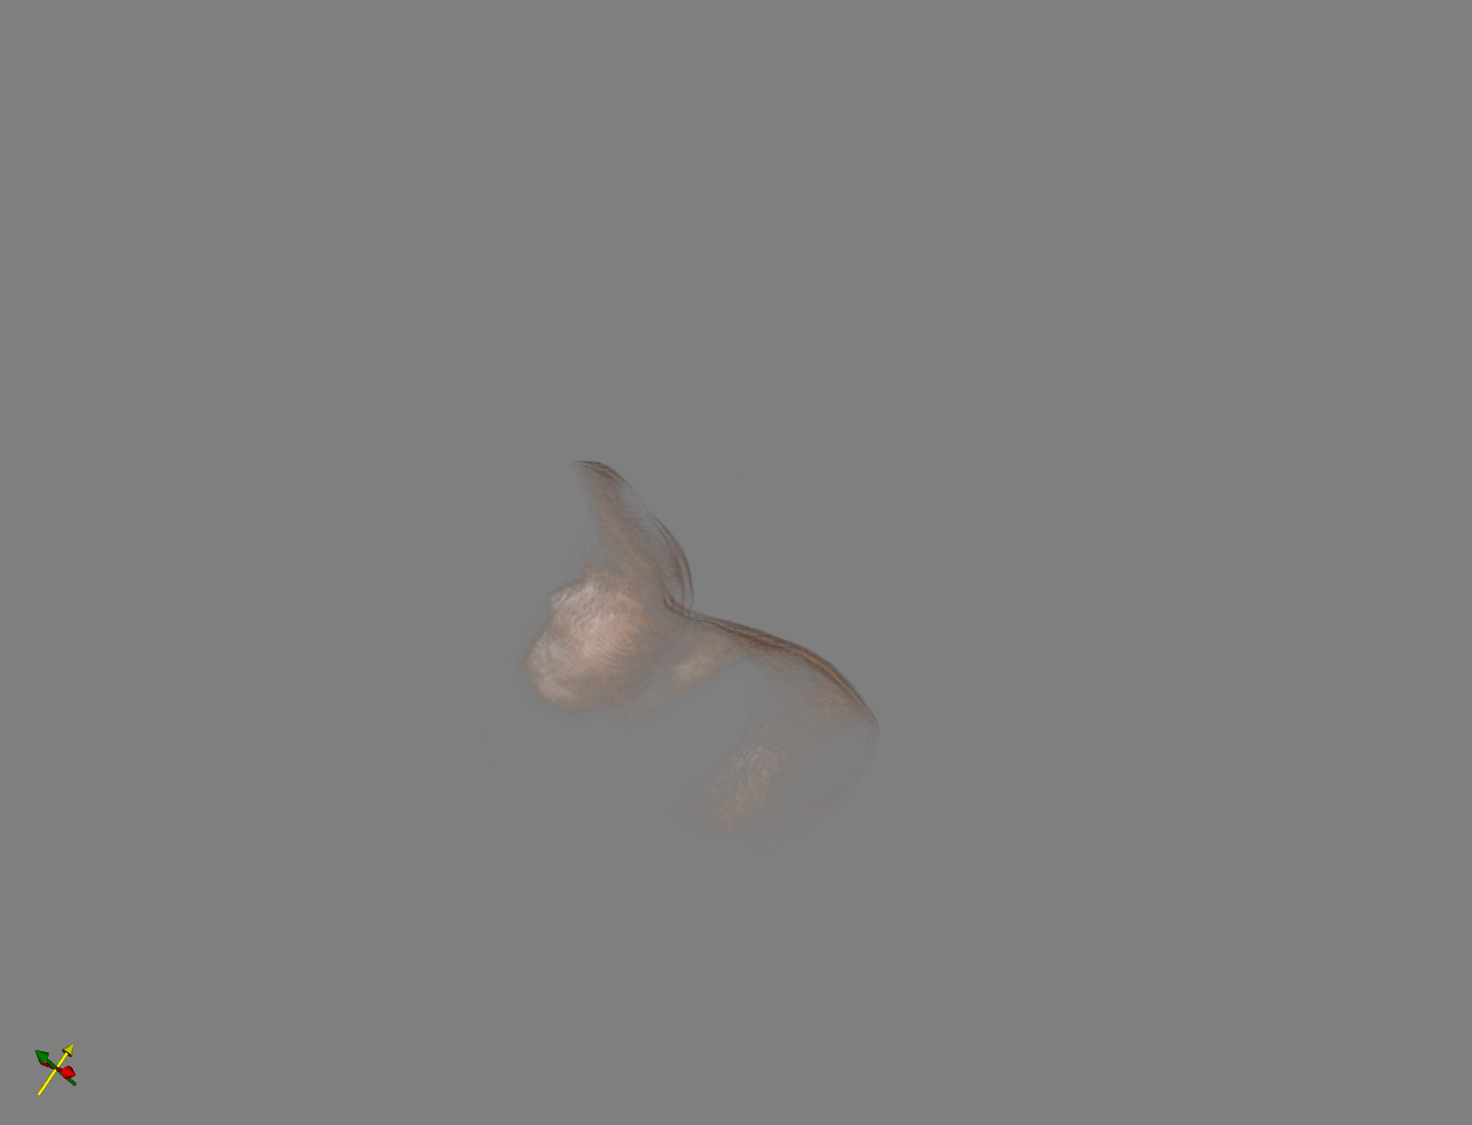

<IPython.core.display.Javascript object>

In [9]:
view(distance)

The *local cartilage thickness* is the distance map value between the lower and upper cartilage surface.

In [10]:
# Compute the distance map in pixels
distance_pixels = masked_distance_pixels(mask)

In [11]:
# This is used to determine how many local dilations are required
# to propagate the thickness to the upper and lower cartilage bounds.
n_dilations = int(np.ceil(np.max(distance_pixels)))
print(n_dilations)

7


This is used to determine how many local dilations are required to propagate the thickness to the upper and lower cartilage bounds.

Propagate the thickness from a masked distance map to boundaries of the mask by first initializing a thickness map by the distance map, then iteratively:

1. Threshold the distance in pixels by the current iteration.
2. Mask the current thickness by this threshold.
3. Run grayscale geodesic dilation for a single iteration on the masked thickness, masking by iteration-thresholded pixel distance.
4. Extract the single dilation layer.
5. Add the single dilation layer to the thickness map.

In [12]:
thickness = propagate_thickness(distance, distance_pixels, mask, max_distance=max_distance)


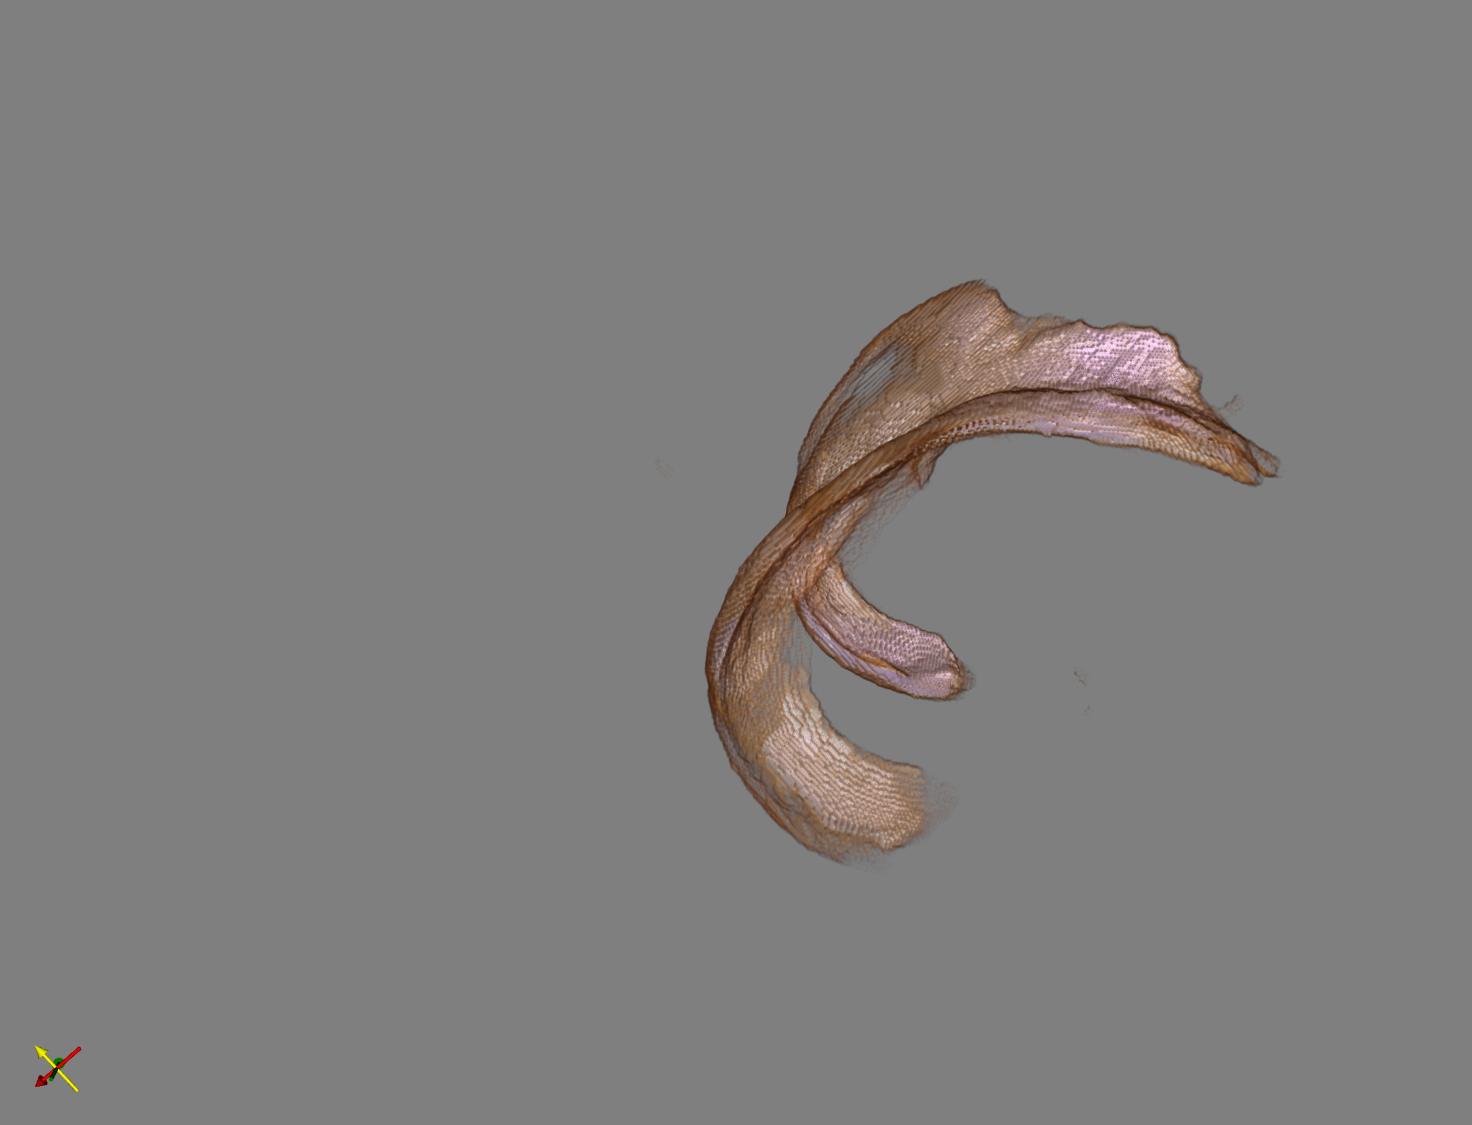
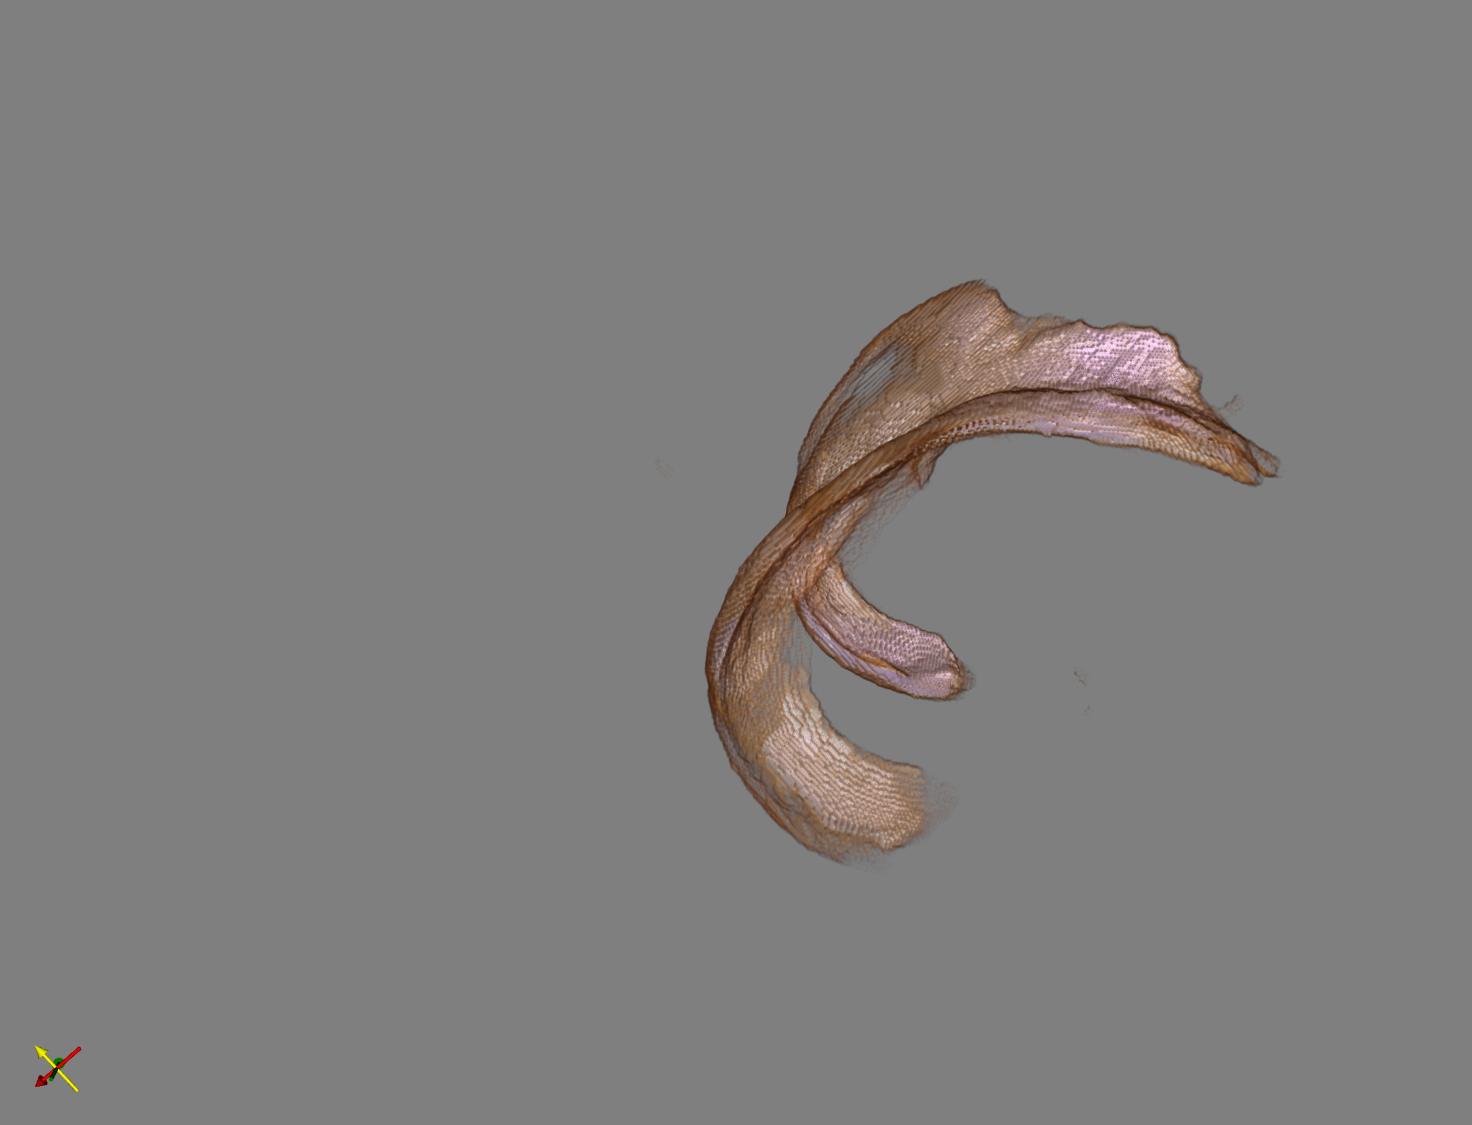

<IPython.core.display.Javascript object>

In [13]:
view(thickness)

### Distance map method

In [14]:
distance = masked_distance(mask, method=DistanceMapMethod.signed_maurer)
distance_pixels = masked_distance_pixels(mask, method=DistanceMapMethod.signed_maurer)
thickness_signed_maurer = propagate_thickness(distance, distance_pixels, mask, max_distance=max_distance)

Parabolic morphology provides the more accurate euclidean-based distance.

In [15]:
distance = masked_distance(mask, method=DistanceMapMethod.parabolic_morphology)
distance_pixels = masked_distance_pixels(mask, method=DistanceMapMethod.parabolic_morphology)
thickness_parabolic_morphology = propagate_thickness(distance, distance_pixels, mask, max_distance=max_distance)


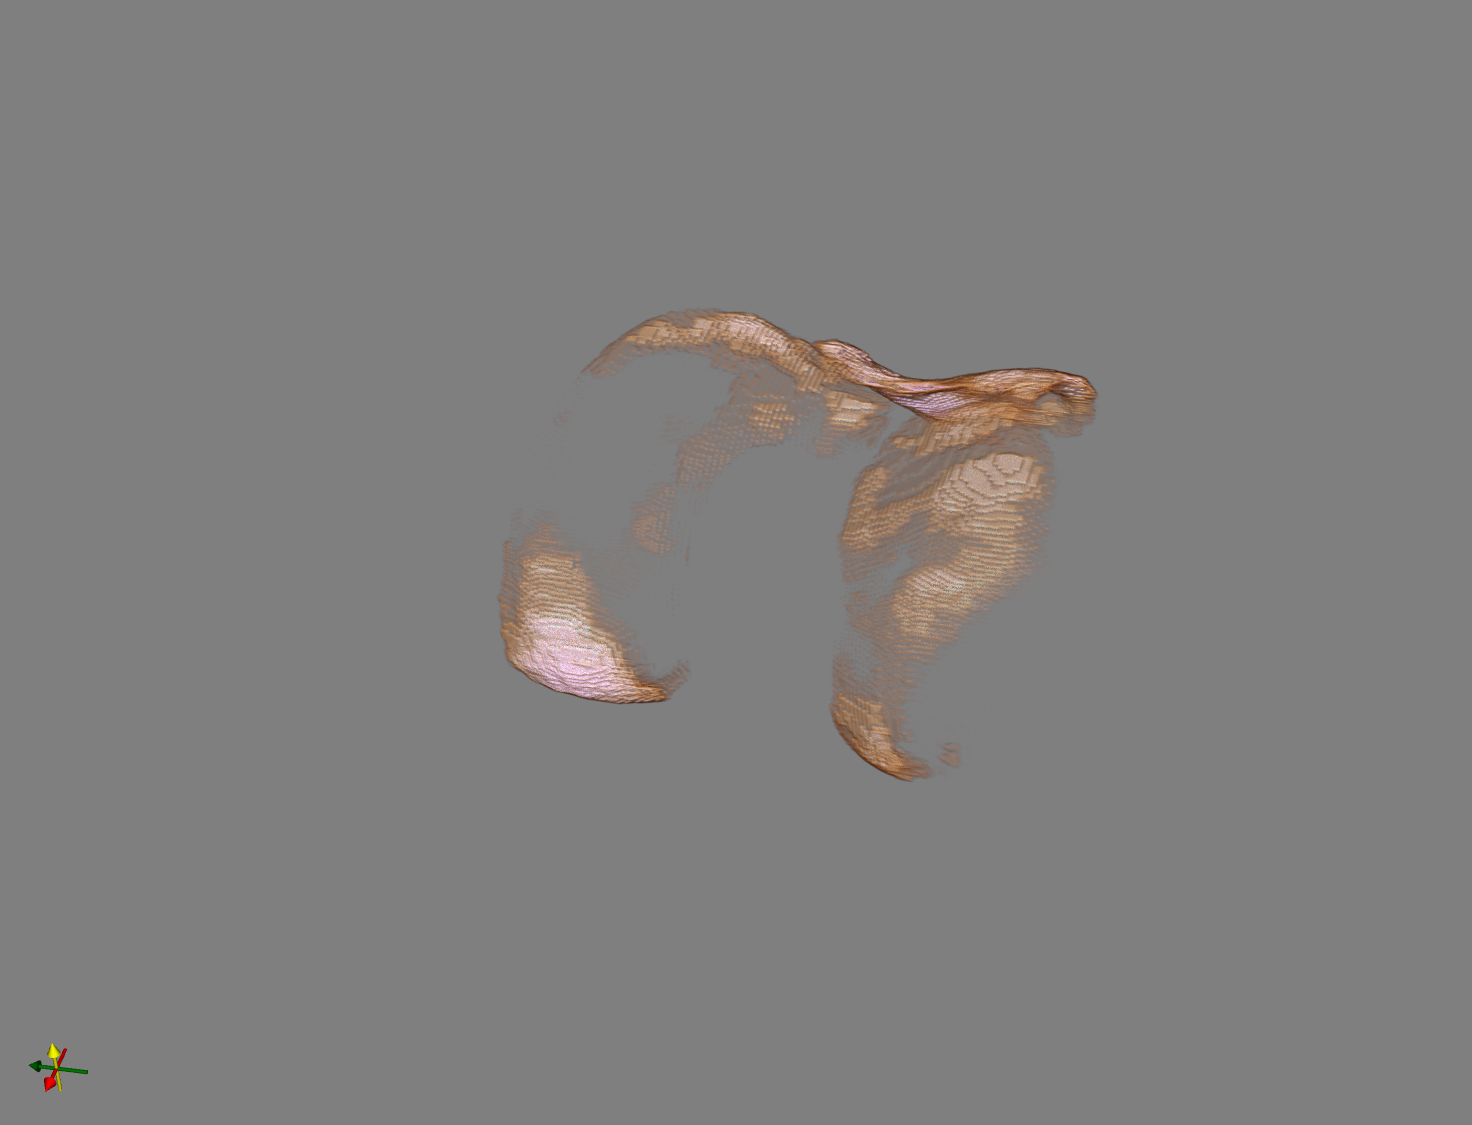
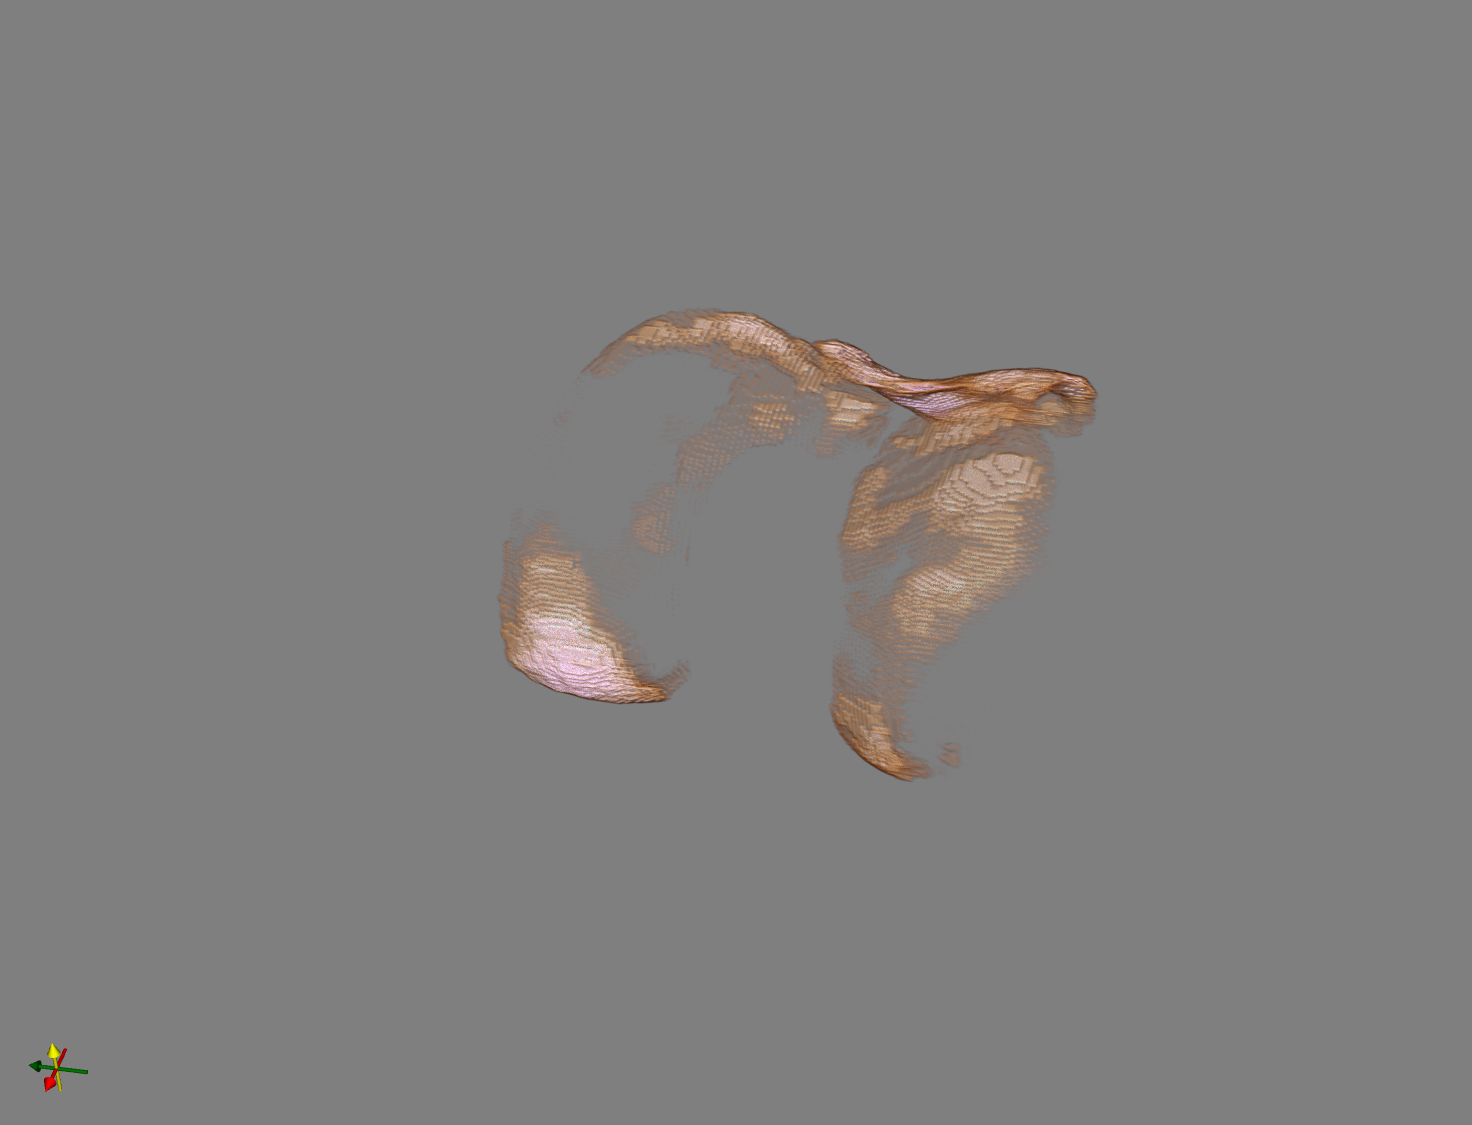

<IPython.core.display.Javascript object>

In [16]:
view(thickness_signed_maurer)

---
## Dependencies

- *For reproducibility, it is important to document computer setup and software versions*    

In [17]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2024-08-29T14:28:51.164202-04:00

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.26.0

Compiler    : MSC v.1933 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
CPU cores   : 24
Architecture: 64bit

numpy: 1.26.3
itk  : 5.3.0



---
<a name="ref"></a>
## References

- *Beare, Richard. "Morphology with parabolic structuring elements", [https://doi.org/10.54294/aq68pt](https://doi.org/10.54294/aq68pt)*

---
<a name="thanks"></a>
## Acknowledgements

- *This work was developed with support in part from the National Institute of Arthritis and Musculoskeletal and Skin Diseases (NIAMS) 
under award numbers [1R44AR074375](https://reporter.nih.gov/search/Naf5qSR3eUStFkMfGm6KpQ/project-details/9777582) and [1R01AR072013](https://reporter.nih.gov/search/eE7eB34dVUGoY1nLF3kZNA/project-details/9368542).*

---
<a name="attribution"></a>

Notebook created using the [template](https://github.com/ORMIRcommunity/templates/blob/main/ORMIR_nb_template.ipynb) of the [ORMIR community](https://ormircommunity.github.io/) (version 1.0, 2023)